Generating dataset: 100%|██████████| 10000/10000 [00:00<00:00, 84904.25it/s]


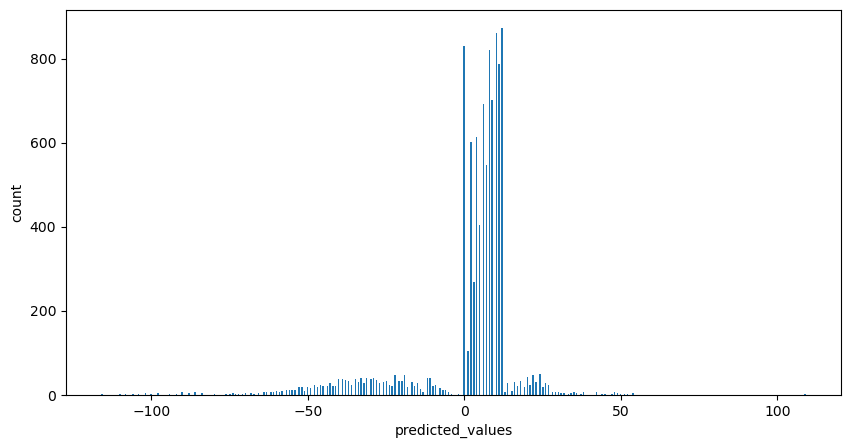

tensor([829])

In [8]:
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset

from train_regressor import create_dataset

ds: TensorDataset = create_dataset(10000)
ys = ds.tensors[1]
plt.figure(figsize=(10,5))
plt.hist(ys.numpy(), bins=500)
plt.xlabel('predicted_values')
plt.ylabel('count')
plt.show()
values, counts = ys.unique(return_counts=True)
counts[values == 0]